# Statistical evaluation of generated sequences

In [1]:
#imports
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

### Approach to statistical evaluation
The main objective of the statistical evaluation is to quantify how much of the statistical properties of the original data is also present in the synthetic data, i.e how statistically similar/distant are the genuine and synthetic data sets.

To quantify this statistical similarity, Kullback-Leibler (KL) divergence is computed. KL divergence is a method from information theory that compares two probability distribution and say how distant they are from each other. KL = 0 means the distributions are identical and the larger the KL is, the more distant the two distributions are from each other. One thing about KL divergence, is that it's asymmetrical. If a symmetrical measure is wanted, one could use Jensen-Shannon (JS) divergence instead. Where KL divergence highlights how distant two distributions are, JS divergence highlights the similarity. Additionally, JS divergence is symmetric and bounded between 0 and 1. 0 meaning identical and 1 meaning completely different.

Both KL and JS divergence will be computed, to highlight both distance and similarity between the two distributions.

But at the moment we have the sequence of data, and not the distribution. We therefore start by normalizing the data and then find it's histogram. If we then normalize the histogram, so the sum of each element equals 1, this histogram will also be the discrete probability distribution (i.e the probability mass function (pmf)) of the data.

When we have the pmf of the data, the KL and JS divergence can be calculated directly from it's formulas.

I'm also using all of the generated data available, meaning VAR and LSTm only have 1 sequence available to match the statistics of the original data set. However, TimeGAN has 800 sequences available. This let's TimeGAN easier match the statistics of the orignal signal, as it has more room for small variations since the statistics is averaged over all the available data.

In [18]:
plt.rcParams.update({'font.size': 14})

def find_histograms(df, bins=10):
    dists = {}
    for feat in df.columns:
        feat_dist, bin_edges = np.histogram(df[feat], density=True, bins=bins, range=(0,1))
        x = [round((bin_edges[i-1] + bin_edges[i])/2, 4) for i in range(1, len(bin_edges))] #Can be used to plot bar plots
        feat_dist += 1e-7 #To avoid division by 0 later
        feat_dist = feat_dist/np.sum(feat_dist)
        dists[feat] = feat_dist
    return dists

# calculate the kl divergence
def kl_div(p, q):
    return np.sum([p[i] * np.log2(p[i]/q[i]) for i in range(len(p))])

# calculate the js divergence
def js_div(p, q):
    m = 0.5 * (p + q)
    return 0.5 * kl_div(p, m) + 0.5 * kl_div(q, m)

def dists_kl_div(test_dists, ori_dists):
    KLs = []
    for key, value in test_dists.items():
        # print(value, ori_dists[key])
        KLs.append(kl_div(value, ori_dists[key]))
    return KLs

def dists_js_div(test_dists, ori_dists):
    JSs = []
    for key, value in test_dists.items():
        # print(value, ori_dists[key])
        JSs.append(js_div(value, ori_dists[key]))
    return JSs

def kl_several_sequences(y, ori_dist):
    KLs = []
    for seq in y:
        hist = find_histograms(pd.DataFrame(seq))
        KL = dists_kl_div(hist, ori_dist)
        KLs.append(KL)
    KLs_reshaped = []
    for i in range(len(KLs[0])):
        y = [seq[i] for seq in KLs]
        KLs_reshaped.append(y)
    
    return KLs_reshaped

def kl_single_sequence(y, ori_dist):
    hist = find_histograms(y)
    KL = dists_kl_div(hist, ori_dist)
    return KL

def plot_divergences3(timegan_div, var_div, lstm_div, y_label):
    barWidth = 1/4
    fig = plt.subplots(figsize =(12, 6)) 

    # Set position of bar on X axis 
    br1 = np.arange(len(timegan_div)) 
    br2 = [x + barWidth for x in br1] 
    br3 = [x + barWidth for x in br2] 

    # Make the plot
    plt.bar(br1, timegan_div, color ='r', width = barWidth, 
            edgecolor ='grey', label ='TimeGAN') 
    plt.bar(br2, var_div, color ='b', width = barWidth, 
            edgecolor ='grey', label ='VAR') 
    plt.bar(br3,  lstm_div, color ='m', width = barWidth, 
            edgecolor ='grey', label ='LSTM') 

    # Adding Xticks 
    plt.xlabel('Dimension', fontweight ='bold', fontsize = 15) 
    plt.ylabel(y_label, fontweight ='bold', fontsize = 15) 
    plt.xticks([r + 1*barWidth for r in range(4)], 
            ['0','1', '2', '3'])
    
    plt.legend()
    plt.grid()
    plt.show() 

def plot_divergences3_box(timegan_div, var_div, lstm_div, y_label):
    barWidth = 1/4
    fig, ax = plt.subplots(figsize =(12, 6)) 

    # Set position of bar on X axis 
    br1 = np.arange(len(timegan_div)) 
    br2 = [x + barWidth for x in br1] 
    br3 = [x + barWidth for x in br2] 

    medianprops = dict(linewidth=2, color='green')

    bplot1 = ax.boxplot(timegan_div, positions=br1, medianprops=medianprops, widths = barWidth, showfliers=False, patch_artist=True) 
    for patch in bplot1['boxes']:
        patch.set_facecolor('red')
    bp2 = ax.bar(br2, var_div, color ='b', width = barWidth, 
            edgecolor ='grey', label ='VAR') 
    bp3 = ax.bar(br3,  lstm_div, color ='m', width = barWidth, 
            edgecolor ='grey', label ='LSTM') 
    
    ax.legend([bplot1["boxes"][0], bp2, bp3], ['TimeGAN', 'VAR','LSTM'])

    # Adding Xticks 
    plt.xlabel('Dimension', fontweight ='bold', fontsize = 15) 
    plt.ylabel(y_label, fontweight ='bold', fontsize = 15) 
    plt.xticks([r + 1*barWidth for r in range(4)], 
            ['0','1', '2', '3'])
    
    plt.grid()
    plt.show() 

def plot_divergences4(timegan_div, timegan_100k_div, var_div, lstm_div, y_label):
    barWidth = 1/5
    fig = plt.subplots(figsize =(12, 6)) 

    # Set position of bar on X axis 
    br1 = np.arange(len(timegan_div)) 
    br2 = [x + barWidth for x in br1] 
    br3 = [x + barWidth for x in br2]
    br4 = [x + barWidth for x in br3]

    # Make the plot
    plt.bar(br1, timegan_div, color ='r', width = barWidth, 
            edgecolor ='grey', label ='TimeGAN 50k') 
    plt.bar(br2, timegan_100k_div, color ='g', width = barWidth, 
            edgecolor ='grey', label ='TimeGAN 100k')
    plt.bar(br3, var_div, color ='b', width = barWidth, 
            edgecolor ='grey', label ='VAR') 
    plt.bar(br4,  lstm_div, color ='m', width = barWidth, 
            edgecolor ='grey', label ='LSTM') 


    # Adding Xticks 
    plt.xlabel('Dimension', fontweight ='bold', fontsize = 15) 
    plt.ylabel(y_label, fontweight ='bold', fontsize = 15) 
    plt.xticks([r + 1.5*barWidth for r in range(len(timegan_div))], 
            [str(i) for i in range(len(timegan_div))])
    
    plt.legend()
    plt.grid()
    plt.show()

def plot_divergences4_box(timegan_div, timegan_100k_div, var_div, lstm_div, y_label):
    barWidth = 1/5
    fig, ax = plt.subplots(figsize =(12, 6)) 

    # Set position of bar on X axis 
    br1 = np.arange(len(timegan_div)) 
    br2 = [x + barWidth for x in br1] 
    br3 = [x + barWidth for x in br2]
    br4 = [x + barWidth for x in br3]

    # Make the plot
#     plt.bar(br1, timegan_div, color ='r', width = barWidth, 
#             edgecolor ='grey', label ='TimeGAN 50k') 
#     plt.bar(br2, timegan_100k_div, color ='g', width = barWidth, 
#             edgecolor ='grey', label ='TimeGAN 100k')
    medianprops = dict(linewidth=2, color='green')
    medianprops2 = dict(linewidth=2, color='red')
    # Make the plot
    bplot1 = ax.boxplot(timegan_div, positions=br1, medianprops=medianprops, widths = barWidth, showfliers=False, patch_artist=True) 
    for patch in bplot1['boxes']:
        patch.set_facecolor('red')
    bplot2 = ax.boxplot(timegan_100k_div, positions=br2, medianprops=medianprops2, widths = barWidth, showfliers=False, patch_artist=True) 
    for patch in bplot2['boxes']:
        patch.set_facecolor('green') 
    bp3 = ax.bar(br3, var_div, color ='b', width = barWidth, 
            edgecolor ='grey', label ='VAR') 
    bp4 = ax.bar(br4,  lstm_div, color ='m', width = barWidth, 
            edgecolor ='grey', label ='LSTM') 

    ax.legend([bplot1["boxes"][0], bplot2["boxes"][0], bp3, bp4], ['TimeGAN 50k', 'TimeGAN 100k', 'VAR','LSTM'])

    # Adding Xticks 
    plt.xlabel('Dimension', fontweight ='bold', fontsize = 15) 
    plt.ylabel(y_label, fontweight ='bold', fontsize = 15) 
    plt.xticks([r + 1.5*barWidth for r in range(len(timegan_div))], 
            [str(i) for i in range(len(timegan_div))])
    
#     plt.legend()
    plt.grid()
    plt.show() 

def plot_divergences4_only_box(short_10k, long_10k, short_50k, long_50k, y_label, sensor_names):
    barWidth = 1/5
    fig, ax = plt.subplots(figsize =(14, 7)) 

    # Set position of bar on X axis 
    br1 = np.arange(len(short_10k)) 
    br2 = [x + barWidth for x in br1] 
    br3 = [x + barWidth for x in br2]
    br4 = [x + barWidth for x in br3]


    medianprops = dict(linewidth=2, color='orange')
    medianprops2 = dict(linewidth=2, color='orange')
    medianprops3 = dict(linewidth=2, color='orange')
    medianprops4 = dict(linewidth=2, color='r')
    # Make the plot
    bplot1 = ax.boxplot(short_10k, positions=br1, medianprops=medianprops, widths = barWidth, showfliers=False, patch_artist=True) 
    for patch in bplot1['boxes']:
        patch.set_facecolor('b')
    bplot2 = ax.boxplot(long_10k, positions=br2, medianprops=medianprops2, widths = barWidth, showfliers=False, patch_artist=True) 
    for patch in bplot2['boxes']:
        patch.set_facecolor('m') 
    bplot3 = ax.boxplot(short_50k, positions=br3, medianprops=medianprops3, widths = barWidth, showfliers=False, patch_artist=True) 
    for patch in bplot3['boxes']:
        patch.set_facecolor('c')
    bplot4 = ax.boxplot(long_50k, positions=br4, medianprops=medianprops4, widths = barWidth, showfliers=False, patch_artist=True) 
    for patch in bplot4['boxes']:
        patch.set_facecolor('y') 


    ax.legend([bplot1["boxes"][0], bplot2["boxes"][0], bplot3["boxes"][0], bplot4["boxes"][0]], ['TimeGAN short 10k', 'TimeGAN long 10k', 'TimeGAN short 50k','TimeGAN long 50k'])

    # Adding Xticks 
    plt.xlabel('Sensor', fontweight ='bold', fontsize = 15) 
    plt.ylabel(y_label, fontweight ='bold', fontsize = 15) 
    plt.xticks([r + 1.5*barWidth for r in range(len(short_10k))], sensor_names)
    plt.grid()
    plt.show() 

def plot_divergences6(timegan_short, timegan_long, var_short, var_long, lstm_short, lstm_long, y_label, sensor_names = [str(i) for i in range(9)]):
    barWidth = 1/7
    fig, ax = plt.subplots(figsize =(12, 7)) 

    # Set position of bar on X axis 
    br1 = np.arange(len(timegan_short)) 
    br2 = [x + barWidth for x in br1] 
    br3 = [x + barWidth for x in br2]
    br4 = [x + barWidth for x in br3]
    br5 = [x + barWidth for x in br4]
    br6 = [x + barWidth for x in br5]
    
    # Make the plot
    plt.bar(br1, timegan_short, color ='r', width = barWidth, 
            edgecolor ='grey', label ='TimeGAN short')
    plt.bar(br2, timegan_long, color ='g', width = barWidth, 
            edgecolor ='grey', label ='TimeGAN long') 
    plt.bar(br3, var_short, color ='b', width = barWidth, 
            edgecolor ='grey', label ='VAR short') 
    plt.bar(br4,  var_long, color ='m', width = barWidth, 
            edgecolor ='grey', label ='VAR long') 
    plt.bar(br5,  lstm_short, color ='c', width = barWidth, 
            edgecolor ='grey', label ='LSTM short') 
    plt.bar(br6,  lstm_long, color ='y', width = barWidth, 
            edgecolor ='grey', label ='LSTM long') 

    # Adding Xticks 
    plt.xlabel('Sensor', fontweight ='bold', fontsize = 15) 
    plt.ylabel(y_label, fontweight ='bold', fontsize = 15) 
    plt.xticks([r + 2.5*barWidth for r in range(len(timegan_short))], sensor_names)
    
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show() 

def plot_divergences6_box(timegan_short, timegan_long, var_short, var_long, lstm_short, lstm_long, y_label, sensor_names = [str(i) for i in range(9)]):
    barWidth = 1/7
    fig, ax = plt.subplots(figsize =(12, 7)) 

    # Set position of bar on X axis 
    br1 = np.arange(len(timegan_short)) 
    br2 = [x + barWidth for x in br1] 
    br3 = [x + barWidth for x in br2]
    br4 = [x + barWidth for x in br3]
    br5 = [x + barWidth for x in br4]
    br6 = [x + barWidth for x in br5]
    
    medianprops = dict(linewidth=2, color='green')
    medianprops2 = dict(linewidth=2, color='red')
    # Make the plot
#     plt.bar(br1, timegan_short, color ='r', width = barWidth, 
#             edgecolor ='grey', label ='TimeGAN short')
    bplot1 = ax.boxplot(timegan_short, positions=br1, medianprops=medianprops, widths = barWidth, showfliers=False, patch_artist=True) 
    for patch in bplot1['boxes']:
        patch.set_facecolor('red')
#     plt.bar(br2, timegan_long, color ='g', width = barWidth, 
#             edgecolor ='grey', label ='TimeGAN long') 
    bplot2 = ax.boxplot(timegan_long, positions=br2, medianprops=medianprops2, widths = barWidth, showfliers=False, patch_artist=True) 
    for patch in bplot2['boxes']:
        patch.set_facecolor('green')

    bp3 = ax.bar(br3, var_short, color ='b', width = barWidth, 
            edgecolor ='grey', label ='VAR short') 
    bp4 = ax.bar(br4,  var_long, color ='m', width = barWidth, 
            edgecolor ='grey', label ='VAR long') 
    bp5 = ax.bar(br5,  lstm_short, color ='c', width = barWidth, 
            edgecolor ='grey', label ='LSTM short') 
    bp6 = ax.bar(br6,  lstm_long, color ='y', width = barWidth, 
            edgecolor ='grey', label ='LSTM long') 

    ax.legend([bplot1["boxes"][0], bplot2["boxes"][0], bp3, bp4, bp5, bp6], ['TimeGAN short', 'TimeGAN long', 'VAR short', 'VAR long','LSTM short','LSTM long'])

    # Adding Xticks 
    plt.xlabel('Sensor', fontweight ='bold', fontsize = 15) 
    plt.ylabel(y_label, fontweight ='bold', fontsize = 15) 
    plt.xticks([r + 2.5*barWidth for r in range(len(timegan_short))], sensor_names)
    
#     plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show() 

In [3]:

dim = 4
scaler = MinMaxScaler()
ori_df = pd.DataFrame(scaler.fit_transform(np.loadtxt(f'sine_data/sine_123_1000_{dim}.csv', delimiter=',', skiprows=1)))


with open(os.path.join('synt_data', 'timeGan_generated_sines', f'syn_sine_50000_{dim}_200_290424_10h40.json'), 'r') as file: #Need to change date and time for each sample
    y = np.array(json.load(file))
print(y.shape)
y_flattened = np.reshape(y, (y.shape[0]*y.shape[1], y.shape[2])) 
timegan_df = pd.DataFrame(y[0])
var_df = pd.DataFrame(np.loadtxt(f'synt_data/VAR/var_sine_{dim}_200.csv', delimiter=',', skiprows=1))
lstm_df = pd.DataFrame(np.loadtxt(f'synt_data/lstm/lstm_sine_{dim}_196_140524_13h25.csv', delimiter=',', skiprows=1))#Need to change date and time for each sample

(800, 200, 4)


In [10]:

ori_dists = find_histograms(ori_df)
timegan_dists = find_histograms(timegan_df)
var_dists = find_histograms(var_df)
lstm_dists = find_histograms(lstm_df)

timegan_KLs = kl_several_sequences(y, ori_dists)
var_KLs = kl_single_sequence(var_df, ori_dists)
lstm_KLs = kl_single_sequence(lstm_df, ori_dists)
    

In [11]:
# Compute the KL divergence for each distribution
timegan_kl = dists_kl_div(timegan_dists, ori_dists)
var_kl = dists_kl_div(var_dists, ori_dists)
lstm_kl = dists_kl_div(lstm_dists, ori_dists)

# Compute the JS divergence for each distribution
timegan_js = dists_js_div(timegan_dists, ori_dists)
var_js = dists_js_div(var_dists, ori_dists)
lstm_js = dists_js_div(lstm_dists, ori_dists)

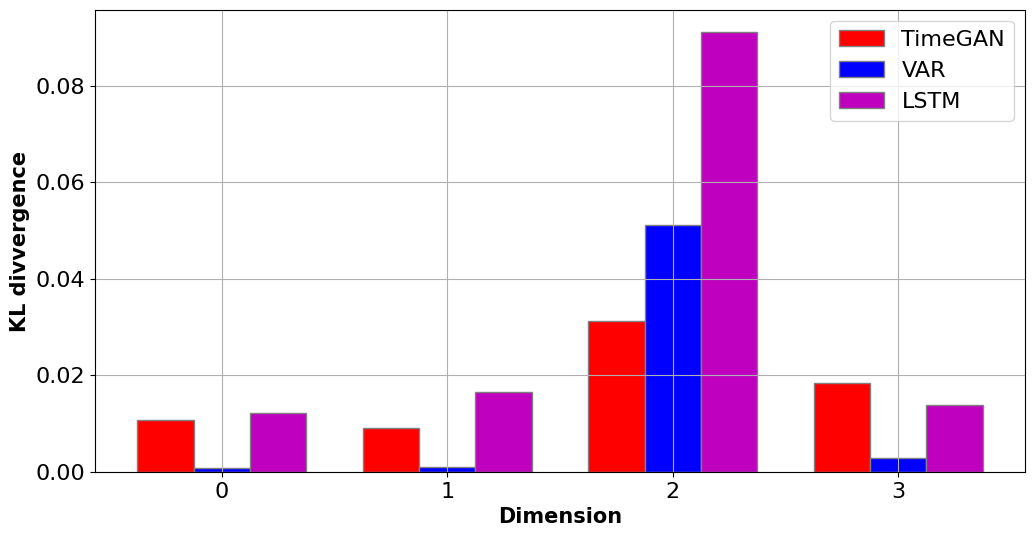

In [14]:
plot_divergences3(np.mean(timegan_KLs, axis=1), var_kl, lstm_kl, "KL divvergence")

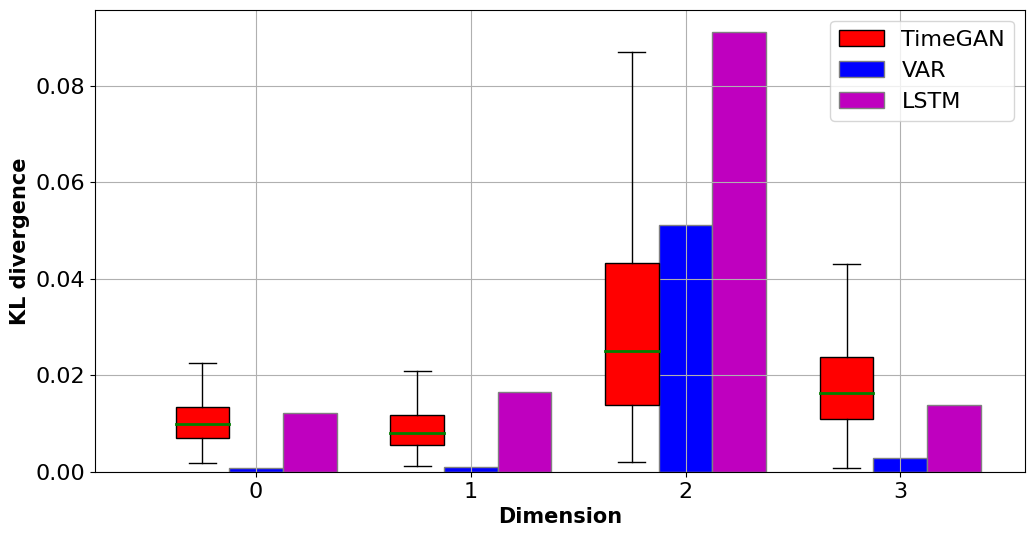

In [25]:
plot_divergences3_box(timegan_KLs, var_KLs, lstm_KLs, "KL divergence")

## KL and JS divergence for the more complicated sines

In [27]:
scaler = MinMaxScaler()
ori_comp_df = pd.DataFrame(scaler.fit_transform(np.loadtxt(f'complex_sine_data/comp_sine_123_1000_6.csv', delimiter=',', skiprows=1)))


with open(os.path.join('synthetic_complex_sines', 'timegan', 'reproducable', 'comp_syn_sine_rep_50000_6_100_220524_00h41.json'), 'r') as file: #Need to change date and time for each sample
    y_50k = np.array(json.load(file))
y_flat = np.reshape(y_50k, (y_50k.shape[0]*y_50k.shape[1], y_50k.shape[2]))
print(y_flat.shape)
timegan_comp_df = pd.DataFrame(y_flat)

with open(os.path.join('synthetic_complex_sines', 'timegan', 'reproducable', 'comp_syn_sine_rep_100000_6_100_220524_17h32.json'), 'r') as file: #Need to change date and time for each sample
    y_100k = np.array(json.load(file))
y_100k_flat = np.reshape(y_100k, (y_100k.shape[0]*y_100k.shape[1], y_100k.shape[2]))
print(y_100k_flat.shape)
timegan_100k_comp_df = pd.DataFrame(y_100k_flat)

var_comp_df = pd.DataFrame(np.loadtxt(f'synthetic_complex_sines/VAR/comp_syn_sine_6_100_120524_13h34.csv', delimiter=',', skiprows=1))
lstm_comp_df = pd.DataFrame(np.loadtxt(f'synthetic_complex_sines/lstm/comp_syn_sine_6_98_120524_14h15.csv', delimiter=',', skiprows=1))#Need to change date and time for each sample

ori_comp_dists = find_histograms(ori_comp_df)
timegan_comp_dists = find_histograms(timegan_comp_df)
timegan_100k_comp_dists = find_histograms(timegan_100k_comp_df)
var_comp_dists = find_histograms(var_comp_df)
lstm_comp_dists = find_histograms(lstm_comp_df)

# print(var_comp_dists)

(90000, 6)
(90000, 6)


In [28]:
# Compute the KL divergence for each distribution
timegan_comp_kl = dists_kl_div(timegan_comp_dists, ori_comp_dists)
timegan_100k_comp_kl = dists_kl_div(timegan_100k_comp_dists, ori_comp_dists)
var_comp_kl = dists_kl_div(var_comp_dists, ori_comp_dists)
lstm_comp_kl = dists_kl_div(lstm_comp_dists, ori_comp_dists)

# Compute the JS divergence for each distribution
timegan_comp_js = dists_js_div(timegan_comp_dists, ori_comp_dists)
timegan_100k_comp_js = dists_js_div(timegan_100k_comp_dists, ori_comp_dists)
var_comp_js = dists_js_div(var_comp_dists, ori_comp_dists)
lstm_comp_js = dists_js_div(lstm_comp_dists, ori_comp_dists)


timegan_50k_comp_KLs = kl_several_sequences(y_50k, ori_comp_dists)
timegan_100k_comp_KLs = kl_several_sequences(y_100k, ori_comp_dists)
var_comp_KLs = kl_single_sequence(var_comp_df, ori_comp_dists)
lstm_comp_KLs = kl_single_sequence(lstm_comp_df, ori_comp_dists)

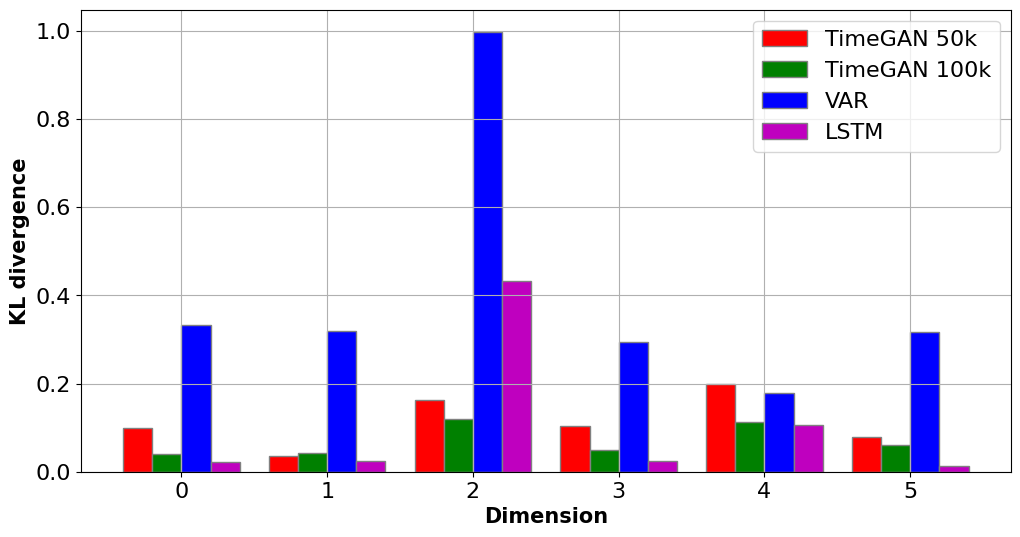

In [30]:
plot_divergences4(timegan_comp_kl, timegan_100k_comp_kl, var_comp_kl, lstm_comp_kl, "KL divergence")

In [21]:
plot_divergences4_box(timegan_50k_comp_KLs, timegan_100k_comp_KLs, var_comp_KLs, lstm_comp_KLs, "KL divergence")

NameError: name 'timegan_50k_comp_KLs' is not defined

## KL divergence for the industrial data

In [5]:
scaler = MinMaxScaler()
ori_ind_df = pd.DataFrame(scaler.fit_transform(np.loadtxt(f'data/sensor_data_norm2_indexless_10days.csv', delimiter=',', skiprows=1)))



with open(os.path.join('synt_data','exp3','gen_sensor_24_26_05_24__18h54.json'), 'r') as file: #Need to change date and time for each sample
    y_short = np.array(json.load(file))
y_flattened = np.reshape(y_short, (y_short.shape[0]*y_short.shape[1], y_short.shape[2]))
# print(y_short[0].shape)
timegan_short_df = pd.DataFrame(y_flattened)

with open(os.path.join('synt_data', 'exp3', 'gen_sensor_100_26_05_24__21h03.json'), 'r') as file: #Need to change date and time for each sample
    y_long = np.array(json.load(file))
y_long_flattened = np.reshape(y_long, (y_long.shape[0]*y_long.shape[1], y_long.shape[2]))
# print(y_long[0].shape)
timegan_long_df = pd.DataFrame(y_long_flattened)

with open(os.path.join('synt_data','exp3','gen_sensor_24_50000_27_05_24__17h16.json'), 'r') as file: #Need to change date and time for each sample
    y_short_50k = np.array(json.load(file))
y_50k_flattened = np.reshape(y_short_50k, (y_short_50k.shape[0]*y_short_50k.shape[1], y_short_50k.shape[2]))
# print(y_short[0].shape)
timegan_short_50k_df = pd.DataFrame(y_50k_flattened)

with open(os.path.join('synt_data','exp3','gen_sensor_100_50000_28_05_24__09h25.json'), 'r') as file: #Need to change date and time for each sample
    y_long_50k = np.array(json.load(file))
y_50k_long_flattened = np.reshape(y_long_50k, (y_long_50k.shape[0]*y_long_50k.shape[1], y_long_50k.shape[2]))
# print(y_short[0].shape)
timegan_long_50k_df = pd.DataFrame(y_50k_long_flattened)

var_short_df = pd.DataFrame(np.loadtxt(f'synt_data/exp3/var_sensor_24.csv', delimiter=',', skiprows=1))
var_long_df = pd.DataFrame(np.loadtxt(f'synt_data/exp3/var_sensor_100.csv', delimiter=',', skiprows=1))
lstm_short_df = pd.DataFrame(np.loadtxt(f'synt_data/exp3/lstm_sensor_24_260524_19h21.csv', delimiter=',', skiprows=1))#Need to change date and time for each sample
lstm_long_df = pd.DataFrame(np.loadtxt(f'synt_data/exp3/lstm_sensor_100_260524_19h21.csv', delimiter=',', skiprows=1))#Need to change date and time for each sample

ori_ind_dists = find_histograms(ori_ind_df)

In [7]:
sensor_names = ['PDT-92534','PT-92523','TIC-92504','TT 92532','FT-92537','TT-92539','PT-92539','ZT 92543','KA 9101']

In [6]:
timegan_short_kl = kl_several_sequences(y_short, ori_ind_dists)
timegan_long_kl = kl_several_sequences(y_long, ori_ind_dists)
timegan_short_50k_kl = kl_several_sequences(y_short_50k, ori_ind_dists)
timegan_long_50k_kl = kl_several_sequences(y_long_50k, ori_ind_dists)
var_short_kl = kl_single_sequence(var_short_df, ori_ind_dists)
var_long_kl = kl_single_sequence(var_long_df, ori_ind_dists)
lstm_short_kl = kl_single_sequence(lstm_short_df, ori_ind_dists)
lstm_long_kl = kl_single_sequence(lstm_long_df, ori_ind_dists)

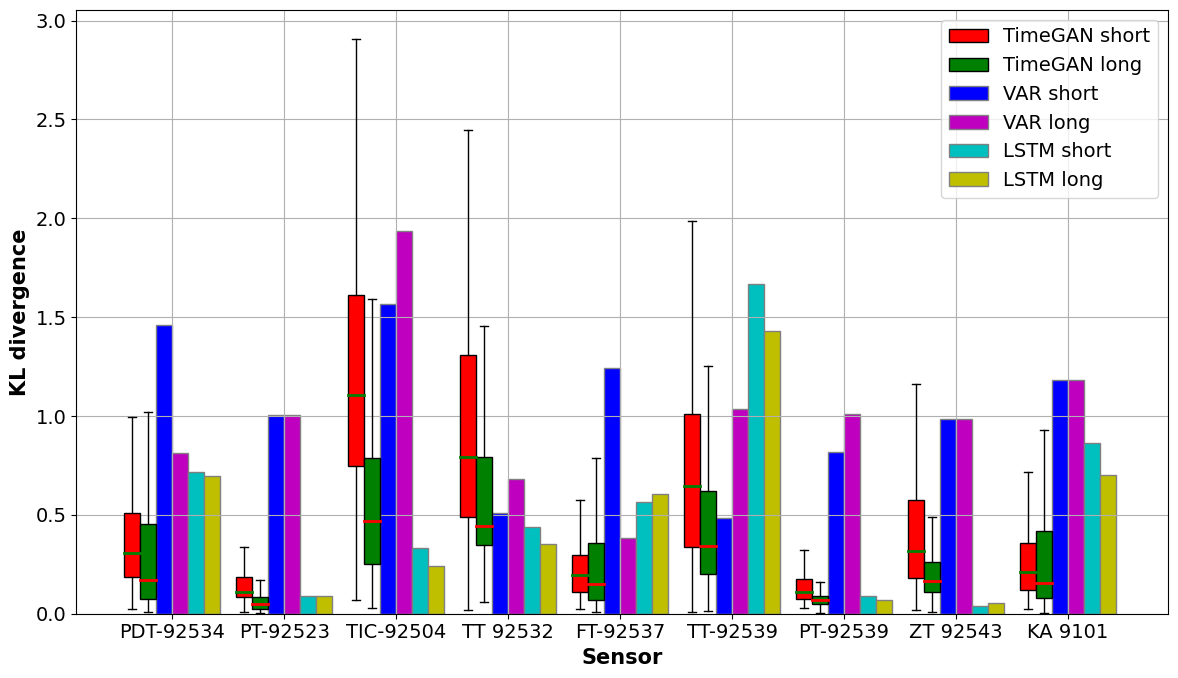

In [31]:
plot_divergences6_box(timegan_short_50k_kl, timegan_long_50k_kl, var_short_kl, var_long_kl, lstm_short_kl, lstm_long_kl, "KL divergence", sensor_names)

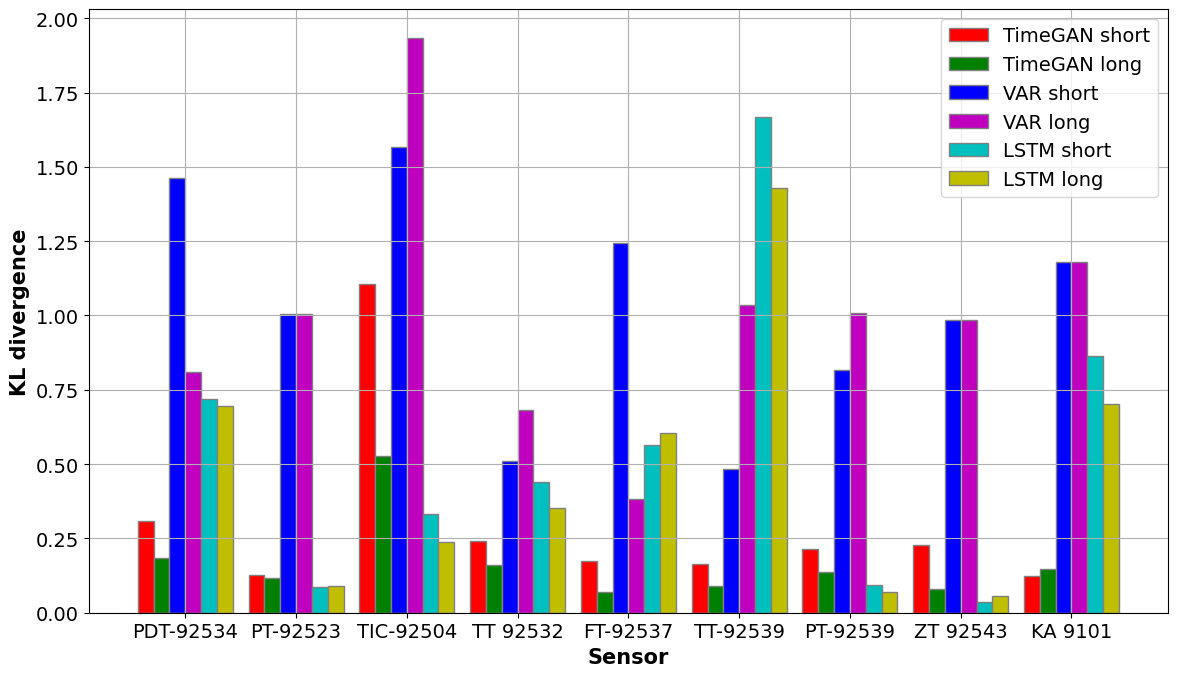

In [30]:

plot_divergences6(np.mean(timegan_short_kl, axis=1), np.mean(timegan_long_kl, axis=1), var_short_kl, var_long_kl, lstm_short_kl, lstm_long_kl, "KL divergence", sensor_names=sensor_names)

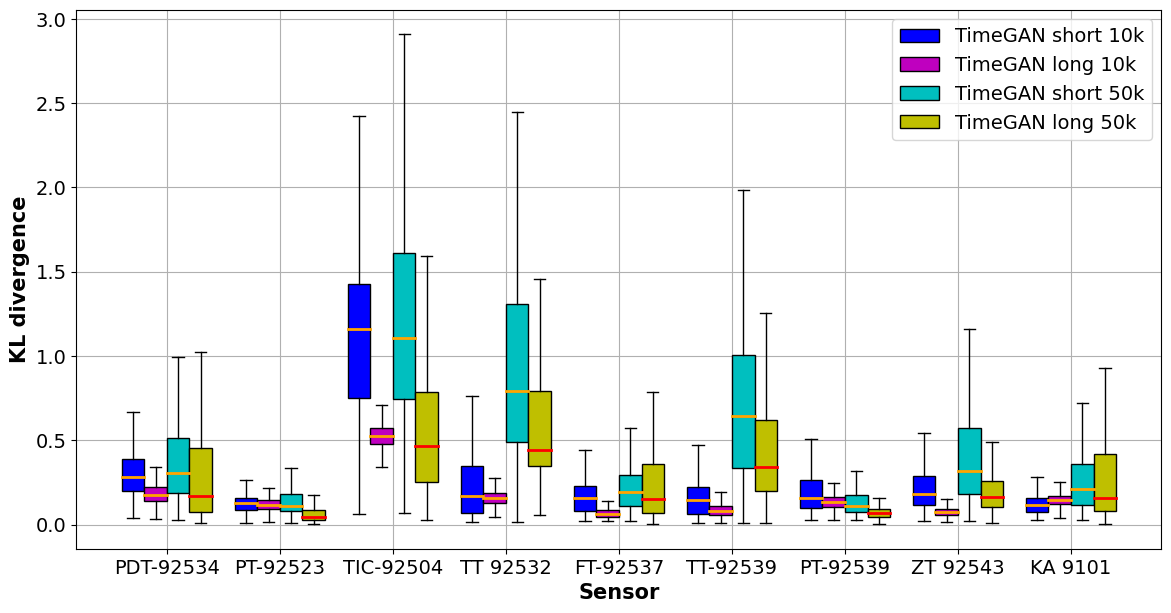

In [19]:
plot_divergences4_only_box(timegan_short_kl, timegan_long_kl, timegan_short_50k_kl, timegan_long_50k_kl, "KL divergence", sensor_names)

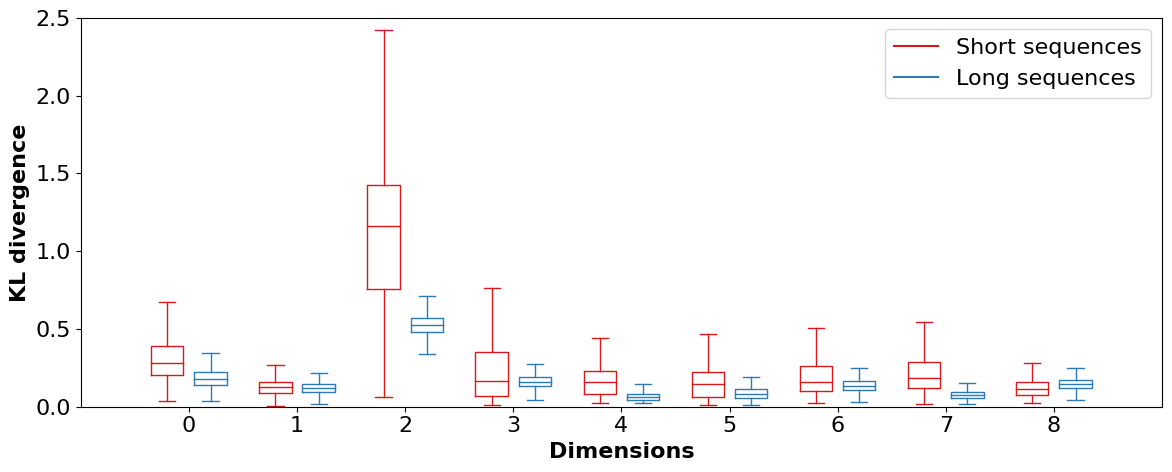

In [70]:
data_a = y_short_reshaped
data_b = y_long_reshaped

ticks = [str(i) for i in range(len(y_short_reshaped))]

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure(figsize=(12,5))

bpl = plt.boxplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Short sequences')
plt.plot([], c='#2C7BB6', label='Long sequences')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
plt.ylim(0, 2.5)
plt.ylabel("KL divergence", fontweight="bold")
plt.xlabel("Dimensions", fontweight="bold")
plt.tight_layout()
# plt.savefig('boxcompare.png')